# Prediksi Suhu Rata-Rata Menggunakan Recurrent Neural Network
## Studi Kasus = Cilacap, Jawa Tengah

#### Code by : https://www.github.com/ridwanakf

## Data

** Sumber data: https://dataonline.bmkg.go.id/data_iklim **

** Data Iklim Harian Cilacap 300 hari terakhir**

** Import library yang dibutuhkan **

In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
%matplotlib inline

** Pakai pandas untuk baca file csv berupa data iklimnya, lalu set index_col='Tanggal' karena itu yang kita pake buat time-series variablenya **

In [2]:
suhu = pd.read_csv('laporan_iklim_harian_cilacap.csv',index_col='Tanggal')

** Cek isi datanya**

In [3]:
suhu.head(1)

,Suhu Minimum (°C),Suhu Maksimum (°C),Suhu Rata-rata (°C),Kelembaban Rata-rata (%),Curah Hujan (mm),Lama Penyinaran (jam),Kecepatan Angin Rata-rata (knot),Arah Angin Terbanyak (deg),Kecepatan Angin Terbesar (knot),Arah Angin Saat Kecepatan Maksimum (deg)
Tanggal,,,,,,,,,,
17/01/2018,0.0,32.2,30.5,66,0.0,0.0,2,N,6,260


** Ubah 'Tanggal' supaya jadi time-series DataFrame pandas **

In [4]:
suhu.index = pd.to_datetime(suhu.index, format='%d/%m/%Y')

** Ambil kolom Suhu Rata-Rata saja **

In [5]:
suhu = suhu.drop(['Curah Hujan (mm)', 'Kelembaban Rata-rata (%)', 'Suhu Minimum (°C)', 'Suhu Maksimum (°C)', 'Lama Penyinaran (jam)', 'Kecepatan Angin Rata-rata (knot)', 'Arah Angin Terbanyak (deg)', 'Kecepatan Angin Terbesar (knot)', 'Arah Angin Saat Kecepatan Maksimum (deg)'], axis=1)

** Cek lagi isi datanya **

In [6]:
suhu.head(5)

,Suhu Rata-rata (°C)
Tanggal,
2018-01-17,30.5
2018-01-18,27.7
2018-01-19,27.6
2018-01-20,27.0
2018-01-21,27.0


** Coba plot datanya **

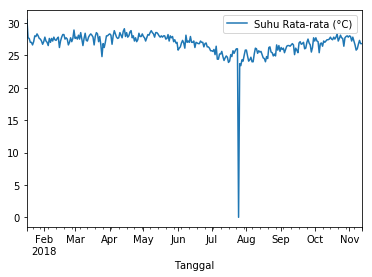

In [7]:
suhu.plot()

### Train Test Split

** Coba prediksi data sebulan kedepan (30 hari) **

In [8]:
train_set = suhu.head(300-30) #data untuk trainnya dari data ke 1-270

In [9]:
test_set = suhu.tail(30) #data untuk testnya dari data 271-300

### Scaling Datanya

** Menggunakan sklearn.preprocessing untuk MinMaxScaler **
** fit_transform hanya train_set-nya aja, kalo test_set-nya cukup di transform **

In [10]:
from sklearn.preprocessing import MinMaxScaler

In [11]:
scaler = MinMaxScaler()

In [12]:
train_scaled = scaler.fit_transform(train_set)

In [13]:
test_scaled = scaler.transform(test_set)

## Membuat Fungsi untuk Batch-nya

In [14]:
def next_batch(training_data,steps):
    
    # Pilih starting point secara acak
    rand_start = np.random.randint(0,len(training_data)-steps) 

    # Buat batch datanya
    y_batch = np.array(training_data[rand_start:rand_start+steps+1]).reshape(1,steps+1)

    return y_batch[:, :-1].reshape(-1, steps, 1), y_batch[:, 1:].reshape(-1, steps, 1) 

## Persiapan Model RNN-nya

** Hyperparameters **

In [15]:
# jumlah fitur, 1 = suhu(t)
num_inputs = 1

# jumlah step di setiap batch. 365 (hari)
num_time_steps = 30

# jumlah neuron
num_neurons = 100

# outputnya, berupa suhu(t+1)
num_outputs = 1

# learning_rate
learning_rate = 0.001

# jumlah iterasi
num_train_iterations = 10001

** Buat placeholder tensorflow X sebagai input, dan y sebagai outputnya**  

In [16]:
input_layer = tf.placeholder(tf.float32, [None, num_time_steps, num_inputs])
output_layer = tf.placeholder(tf.float32, [None, num_time_steps, num_outputs])

** Buat layer RNN-nya, menggunakan fungsi dari library tensorflow**

** Untuk fungsi aktivasi-nya menggunakan ReLu**

** ReLu(x) = max(0, x) **

In [17]:
cell = tf.contrib.rnn.OutputProjectionWrapper(
    tf.contrib.rnn.BasicRNNCell(num_units=num_neurons, activation=tf.nn.relu),
    output_size=num_outputs) 

In [18]:
outputs, states = tf.nn.dynamic_rnn(cell, input_layer, dtype=tf.float32)

### Fungsi Loss dan Optimizer-nya

** Menggunakan Squared Error untuk menghitung lossnya, dan menggunakan GradientDescent sebagai optimizernya **

In [19]:
loss = tf.square(outputs - output_layer)
optimizer = tf.train.GradientDescentOptimizer(learning_rate=learning_rate)
train = optimizer.minimize(loss)

** Inisial global variable tensorflow **

In [20]:
init = tf.global_variables_initializer()

** Buat instance saver untuk nyimpen model RNN-nya nanti **

In [21]:
saver = tf.train.Saver()

### Session

** Jalankan training-nya **

In [22]:
gpu_options = tf.GPUOptions(per_process_gpu_memory_fraction=0.9)

In [23]:
with tf.Session(config=tf.ConfigProto(gpu_options=gpu_options)) as sess:
    sess.run(init)
    
    for iteration in range(num_train_iterations):
        
        X_batch, y_batch = next_batch(train_scaled,num_time_steps)
        sess.run(train, feed_dict={input_layer: X_batch, output_layer: y_batch})
        
        if iteration % 100 == 0:
            
            error = loss.eval(feed_dict={input_layer: X_batch, output_layer: y_batch})
            print("iterasi ke -", iteration, "\t\tloss:", error)
    
    # Simpan Modelnya
    saver.save(sess, "./prediksi_suhu_ratarata")

iterasi ke - 0 		loss: 0.92267
iterasi ke - 100 		loss: 0.0348556
iterasi ke - 200 		loss: 0.0168142
iterasi ke - 300 		loss: 0.0127463
iterasi ke - 400 		loss: 0.00874054
iterasi ke - 500 		loss: 0.0278913
iterasi ke - 600 		loss: 0.00339981
iterasi ke - 700 		loss: 0.00201337
iterasi ke - 800 		loss: 0.0011096
iterasi ke - 900 		loss: 0.000558855
iterasi ke - 1000 		loss: 0.000576086
iterasi ke - 1100 		loss: 0.00025227
iterasi ke - 1200 		loss: 0.00134632
iterasi ke - 1300 		loss: 0.000772998
iterasi ke - 1400 		loss: 0.0259706
iterasi ke - 1500 		loss: 0.0246879
iterasi ke - 1600 		loss: 0.000719336
iterasi ke - 1700 		loss: 0.0240221
iterasi ke - 1800 		loss: 0.00108613
iterasi ke - 1900 		loss: 0.0254568
iterasi ke - 2000 		loss: 0.000506147
iterasi ke - 2100 		loss: 0.000468329
iterasi ke - 2200 		loss: 0.000780766
iterasi ke - 2300 		loss: 0.0253733
iterasi ke - 2400 		loss: 0.000417079
iterasi ke - 2500 		loss: 0.000371154
iterasi ke - 2600 		loss: 0.000384003
iterasi ke - 270

______

## Prediksi (Test Data)

** Menggunakan test_set (30 hari paling baru) **

In [24]:
test_set

,Suhu Rata-rata (°C)
Tanggal,
2018-10-14,27.5
2018-10-15,27.8
2018-10-16,27.5
2018-10-17,27.4
2018-10-18,27.8
2018-10-19,27.5
2018-10-20,27.8
2018-10-21,28.3
2018-10-22,27.2


# Generate Datanya

In [25]:
with tf.Session() as sess:
    
    # restore model yang udah disimpen pas training tadi
    saver.restore(sess, "./prediksi_suhu_ratarata")

    # Bikin array yang isinya data 30 hari terakhir
    # untuk diprediksi
    train_seed = list(train_scaled[-30:])
    
    for iteration in range(30):
        X_batch = np.array(train_seed[-num_time_steps:]).reshape(1, num_time_steps, 1)
        y_pred = sess.run(outputs, feed_dict={input_layer: X_batch})
        train_seed.append(y_pred[0, -1, 0])

INFO:tensorflow:Restoring parameters from ./prediksi_suhu_ratarata


** Show the result of the predictions. **

In [26]:
train_seed

[array([ 0.8557377]),
 array([ 0.84590164]),
 array([ 0.83278689]),
 array([ 0.88196721]),
 array([ 0.88852459]),
 array([ 0.87540984]),
 array([ 0.87868852]),
 array([ 0.8852459]),
 array([ 0.85245902]),
 array([ 0.8557377]),
 array([ 0.8852459]),
 array([ 0.90163934]),
 array([ 0.88196721]),
 array([ 0.87213115]),
 array([ 0.83606557]),
 array([ 0.85901639]),
 array([ 0.90819672]),
 array([ 0.89180328]),
 array([ 0.90819672]),
 array([ 0.89180328]),
 array([ 0.88852459]),
 array([ 0.83278689]),
 array([ 0.87868852]),
 array([ 0.88196721]),
 array([ 0.86557377]),
 array([ 0.89180328]),
 array([ 0.8852459]),
 array([ 0.89180328]),
 array([ 0.89836066]),
 array([ 0.89836066]),
 0.88860726,
 0.88572466,
 0.88483965,
 0.88484335,
 0.88486183,
 0.88480413,
 0.88477671,
 0.88473928,
 0.88460112,
 0.88458002,
 0.88464355,
 0.88464916,
 0.88454342,
 0.88443422,
 0.88430476,
 0.88435781,
 0.88446057,
 0.88440442,
 0.8843652,
 0.88424611,
 0.88413107,
 0.88396192,
 0.88401544,
 0.88399971,
 0.8

** Pakai invers_transform untuk membalikkan nilai yang tadinya sudah di scale **

In [27]:
results = scaler.inverse_transform(np.array(train_seed[:30]).reshape(num_time_steps,1))

** Bikin kolom baru bernama 'Prediksi' untuk membandingkan dengan data aslinya **

In [28]:
test_set['Prediksi'] = results

C:\Program Files (x86)\Microsoft Visual Studio\Shared\Anaconda3_64\envs\tfdeeplearning\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


** lihat test_set nya **

In [29]:
test_set

,Suhu Rata-rata (°C),Prediksi
Tanggal,,
2018-10-14,27.5,26.1
2018-10-15,27.8,25.8
2018-10-16,27.5,25.4
2018-10-17,27.4,26.9
2018-10-18,27.8,27.1
2018-10-19,27.5,26.7
2018-10-20,27.8,26.8
2018-10-21,28.3,27.0
2018-10-22,27.2,26.0


** Plot kolomnya untuk membandingkan **

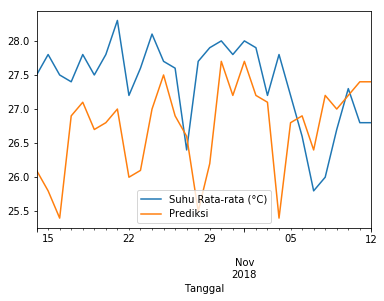

In [30]:
test_set.plot()